# Dev Phase 5: Full Model Training

Production training notebook for the MIGT-TVDT distributional forecasting model.

**Features:**
- Data copied to VM for faster I/O
- Mixed precision training (AMP) for A100 optimization
- Gradient accumulation (effective batch size 256)
- Cosine learning rate schedule with warmup
- Early stopping on validation loss
- Checkpoint management (latest + best + top-k)
- Optional WandB logging
- Resume from checkpoint support

**Expected Runtime:** 3-4 hours on A100 (with early stopping)

**Output for Phase 6:**
- `checkpoint_best.pt`: Best model weights
- `training_history.json`: Loss curves and metrics
- Console logs for monitoring

## 1. Environment Setup

In [1]:
def setup_environment():
    """
    Mount Google Drive and configure paths.

    Creates necessary directories on VM for faster I/O during training.
    Data will be copied from Drive to VM before training starts.

    Returns:
        dict: Path configuration with keys:
            drive_base: Path to project root on Drive
            vm_data: Path to data on VM (faster I/O)
            vm_outputs: Path to outputs on VM
            drive_outputs: Path to outputs on Drive (for persistence)
    """
    from google.colab import drive
    from pathlib import Path
    import sys
    import os

    # Mount Drive
    drive.mount('/content/drive')

    # Install dependencies (pyyaml typically pre-installed but ensure)
    import subprocess
    subprocess.run(['pip', 'install', '-q', 'pyyaml'], check=True)

    # Project paths
    drive_base = Path('/content/drive/MyDrive/Colab Notebooks/Transformers/FP')

    # Add source directory to Python path
    src_path = str(drive_base / 'src')
    if src_path not in sys.path:
        sys.path.insert(0, src_path)

    # VM paths for faster I/O
    vm_data = Path('/content/data')
    vm_outputs = Path('/content/outputs')

    # Create VM directories
    vm_data.mkdir(parents=True, exist_ok=True)
    vm_outputs.mkdir(parents=True, exist_ok=True)

    # Output directory on Drive for persistence
    drive_outputs = drive_base / 'outputs'
    drive_outputs.mkdir(parents=True, exist_ok=True)

    paths = {
        'drive_base': drive_base,
        'drive_data': drive_base / 'data' / 'processed',
        'vm_data': vm_data,
        'vm_outputs': vm_outputs,
        'drive_outputs': drive_outputs,
        'configs': drive_base / 'configs'
    }

    print(f"Drive base: {paths['drive_base']}")
    print(f"VM data: {paths['vm_data']}")
    print(f"VM outputs: {paths['vm_outputs']}")

    return paths

paths = setup_environment()

Mounted at /content/drive
Drive base: /content/drive/MyDrive/Colab Notebooks/Transformers/FP
VM data: /content/data
VM outputs: /content/outputs


In [2]:
def verify_gpu():
    """
    Verify GPU availability and display specifications.

    Training requires A100 GPU with 80GB VRAM for optimal performance.
    The model fits in ~20GB peak VRAM with batch_size=128.

    Returns:
        torch.device: CUDA device if available, else CPU

    Raises:
        RuntimeError: If no GPU is available
    """
    import torch

    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")

    if not torch.cuda.is_available():
        raise RuntimeError(
            "GPU not available. Training requires A100 GPU. "
            "Check Colab runtime settings."
        )

    device = torch.device('cuda')
    props = torch.cuda.get_device_properties(0)

    print(f"GPU: {props.name}")
    print(f"VRAM: {props.total_memory / 1e9:.1f} GB")
    print(f"Compute capability: {props.major}.{props.minor}")

    # Check for A100
    if 'A100' in props.name:
        print("A100 detected - optimal configuration")
    else:
        print(f"Warning: Expected A100, got {props.name}. May need to adjust batch size.")

    return device

device = verify_gpu()

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: NVIDIA A100-SXM4-80GB
VRAM: 85.2 GB
Compute capability: 8.0
A100 detected - optimal configuration


## 2. Data Preparation

In [3]:
def copy_data_to_vm(paths):
    """
    Copy processed data from Google Drive to VM for faster I/O.

    Training I/O is significantly faster from VM local storage compared
    to Google Drive. This copies the feature parquet file (~500MB-1GB)
    to the VM before training begins.

    Args:
        paths: dict with 'drive_data' and 'vm_data' Path objects

    Returns:
        Path: Location of data file on VM
    """
    import shutil
    import os

    source_file = paths['drive_data'] / 'nq_features_full.parquet'
    dest_file = paths['vm_data'] / 'nq_features_full.parquet'

    if not source_file.exists():
        raise FileNotFoundError(
            f"Data file not found: {source_file}\n"
            "Run Dev Phase 2 (feature engineering) first."
        )

    # Copy if not already present or if source is newer
    if not dest_file.exists():
        print(f"Copying data to VM...")
        print(f"  Source: {source_file}")
        print(f"  Dest: {dest_file}")
        shutil.copy2(source_file, dest_file)
        print(f"  Size: {dest_file.stat().st_size / 1e6:.1f} MB")
    else:
        print(f"Data already on VM: {dest_file}")
        print(f"  Size: {dest_file.stat().st_size / 1e6:.1f} MB")

    return dest_file

data_path = copy_data_to_vm(paths)

Copying data to VM...
  Source: /content/drive/MyDrive/Colab Notebooks/Transformers/FP/data/processed/nq_features_full.parquet
  Dest: /content/data/nq_features_full.parquet
  Size: 234.8 MB


## 3. Configuration Loading

In [4]:
def load_configs(config_dir):
    """
    Load model and training configurations from YAML files.

    Configurations are stored in configs/ directory:
    - model_config.yaml: Architecture parameters (d_model, layers, etc.)
    - training_config.yaml: Training hyperparameters (lr, batch_size, etc.)

    Args:
        config_dir: Path to configs directory

    Returns:
        tuple: (model_config, train_config) dictionaries
    """
    import yaml
    from pathlib import Path

    config_dir = Path(config_dir)

    # Load model config
    with open(config_dir / 'model_config.yaml') as f:
        model_config = yaml.safe_load(f)

    # Load training config
    with open(config_dir / 'training_config.yaml') as f:
        train_config = yaml.safe_load(f)

    # Display key parameters
    print("Model Configuration:")
    print(f"  d_model: {model_config['model']['d_model']}")
    print(f"  n_temporal_layers: {model_config['model']['n_temporal_layers']}")
    print(f"  n_variable_layers: {model_config['model']['n_variable_layers']}")
    print(f"  n_variables: {model_config['model']['n_variables']}")
    print(f"  n_horizons: {model_config['model']['n_horizons']}")
    print(f"  n_quantiles: {model_config['model']['n_quantiles']}")

    print("\nTraining Configuration:")
    print(f"  batch_size: {train_config['training']['batch_size']}")
    print(f"  gradient_accumulation: {train_config['training']['gradient_accumulation_steps']}")
    effective_batch = (
        train_config['training']['batch_size'] *
        train_config['training']['gradient_accumulation_steps']
    )
    print(f"  effective_batch_size: {effective_batch}")
    print(f"  max_epochs: {train_config['training']['max_epochs']}")
    print(f"  learning_rate: {train_config['optimizer']['lr']}")
    print(f"  early_stopping_patience: {train_config['training']['early_stopping_patience']}")

    return model_config, train_config

model_config, train_config = load_configs(paths['configs'])

Model Configuration:
  d_model: 256
  n_temporal_layers: 4
  n_variable_layers: 2
  n_variables: 24
  n_horizons: 5
  n_quantiles: 7

Training Configuration:
  batch_size: 192
  gradient_accumulation: 2
  effective_batch_size: 384
  max_epochs: 2
  learning_rate: 0.0001
  early_stopping_patience: 10


## 4. Model and Data Initialization

In [5]:
def initialize_model(model_config, device):
    """
    Initialize the MIGT-TVDT model.

    Creates model instance and moves to GPU. Displays parameter counts
    by component for verification against engineering spec (~4M params).

    Args:
        model_config: Model configuration dictionary
        device: torch.device for model placement

    Returns:
        MIGT_TVDT: Initialized model on device
    """
    from model.migt_tvdt import MIGT_TVDT

    print("Initializing model...")
    model = MIGT_TVDT(model_config['model'])
    model = model.to(device)

    # Display parameter counts
    param_counts = model.count_parameters_by_component()
    print("\nParameter counts by component:")
    for name, count in param_counts.items():
        if name != 'total':
            print(f"  {name}: {count:,}")
    print(f"  Total: {param_counts['total']:,}")

    return model

model = initialize_model(model_config, device)

Initializing model...

Parameter counts by component:
  revin: 48
  input_embedding: 37,328
  temporal_layers: 3,159,040
  temporal_aggregation: 131,840
  variable_layers: 1,579,520
  gated_norms: 132,608
  output_pool: 1,573,120
  quantile_head: 253,480
  Total: 6,866,984


In [6]:
def initialize_data(data_path, train_config):
    from data.dataset import NQDataModule

    print("Initializing data module...")

    data_config = train_config['data']

    data_module = NQDataModule(
        data_path=data_path,
        batch_size=train_config['training']['batch_size'],
        num_workers=data_config['num_workers'],
        pin_memory=data_config['pin_memory'],
        train_end="2021-12-31",
        val_end="2023-12-31",
        subsample_fraction=data_config.get('subsample_fraction'),
        subsample_seed=data_config.get('subsample_seed', 42)
    )

    data_module.setup()

    print(f"\nDataloader batch counts:")
    print(f"  Train batches: {len(data_module.train_dataloader()):,}")
    print(f"  Val batches: {len(data_module.val_dataloader()):,}")
    print(f"  Test batches: {len(data_module.test_dataloader()):,}")

    return data_module

data_module = initialize_data(data_path, train_config)

Initializing data module...
Loading data from /content/data/nq_features_full.parquet
Features: 24
Targets: 5
Split statistics:
  Train: 808,996 samples (2010-06-07 to 2021-12-31)
  Val:   141,516 samples (2022-01-02 to 2023-12-29)
  Test:  136,284 samples (2024-01-02 to 2025-12-03)

Temporal gaps:
  Train-Val gap: 49.1 hours
  Val-Test gap: 74.1 hours
  Purged samples: ~576 total (~288 per gap)
[PASS] No data leakage detected:
  Train-Val gap: 49.1 hours
  Val-Test gap: 74.1 hours

Dataset sizes:
  Train: 40,435
  Val:   141,228
  Test:  135,996

Dataloader batch counts:
  Train batches: 210
  Val batches: 736
  Test batches: 709


## 5. Training Configuration

In [7]:
# Training options
USE_WANDB = False  # Set True to enable WandB logging
RESUME_FROM_CHECKPOINT = None  # Set to checkpoint path to resume, e.g., paths['vm_outputs'] / 'checkpoint_latest.pt'

print(f"WandB logging: {USE_WANDB}")
print(f"Resume from: {RESUME_FROM_CHECKPOINT}")

WandB logging: False
Resume from: None


In [8]:
def setup_wandb(use_wandb, train_config, model_config):
    """
    Initialize Weights & Biases logging if enabled.

    WandB provides experiment tracking with:
    - Loss curves and metric visualization
    - Hyperparameter logging
    - Model artifact versioning

    Args:
        use_wandb: Whether to enable WandB
        train_config: Training configuration
        model_config: Model configuration

    Returns:
        wandb module or None
    """
    if not use_wandb:
        print("WandB disabled - using console logging only")
        return None

    try:
        import wandb

        project_name = train_config.get('logging', {}).get('project_name', 'nq-futures-dist')

        # Combine configs for logging
        full_config = {
            'model': model_config['model'],
            'training': train_config['training'],
            'optimizer': train_config['optimizer'],
            'scheduler': train_config['scheduler']
        }

        wandb.init(
            project=project_name,
            config=full_config,
            name=f"train_{wandb.util.generate_id()}"
        )

        print(f"WandB initialized: {project_name}")
        print(f"  Run: {wandb.run.name}")
        print(f"  URL: {wandb.run.url}")

        return wandb

    except ImportError:
        print("WandB not installed - logging disabled")
        return None
    except Exception as e:
        print(f"WandB initialization failed: {e}")
        return None

wandb_logger = setup_wandb(USE_WANDB, train_config, model_config)

WandB disabled - using console logging only


In [9]:
def create_trainer_instance(model, model_config, train_config, data_module, output_dir, wandb_logger):
    """
    Create Trainer instance with all configurations.

    The Trainer handles:
    - Forward/backward passes with mixed precision (AMP)
    - Gradient accumulation for effective batch size
    - Learning rate scheduling (warmup + cosine annealing)
    - Gradient clipping for stability
    - Early stopping on validation loss
    - Checkpoint management

    Args:
        model: MIGT_TVDT model instance
        model_config: Model configuration
        train_config: Training configuration
        data_module: NQDataModule with dataloaders
        output_dir: Directory for checkpoints
        wandb_logger: WandB module or None

    Returns:
        Trainer: Configured trainer instance
    """
    from training.trainer import Trainer

    # Merge configs for trainer
    full_config = {**model_config, **train_config}

    trainer = Trainer(
        model=model,
        config=full_config,
        train_loader=data_module.train_dataloader(),
        val_loader=data_module.val_dataloader(),
        output_dir=output_dir,
        logger=wandb_logger
    )

    print("\nTrainer initialized:")
    print(f"  Output directory: {output_dir}")
    print(f"  Mixed precision: {trainer.use_amp}")
    print(f"  Gradient accumulation: {trainer.grad_accum_steps}")
    print(f"  Gradient clipping: {trainer.grad_clip_norm}")
    print(f"  Early stopping patience: {trainer.early_stopping.patience}")

    return trainer

trainer = create_trainer_instance(
    model, model_config, train_config, data_module,
    paths['vm_outputs'], wandb_logger
)


Trainer initialized:
  Output directory: /content/outputs
  Mixed precision: True
  Gradient accumulation: 2
  Gradient clipping: 1.0
  Early stopping patience: 10


/content/drive/MyDrive/Colab Notebooks/Transformers/FP/src/training/trainer.py:196: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler(enabled=self.use_amp)


In [10]:
def maybe_resume_from_checkpoint(trainer, checkpoint_path):
    """
    Resume training from checkpoint if specified.

    Loads model weights, optimizer state, scheduler state, and
    training progress (epoch, best loss) from checkpoint.

    Args:
        trainer: Trainer instance
        checkpoint_path: Path to checkpoint or None

    Returns:
        bool: True if resumed, False otherwise
    """
    if checkpoint_path is None:
        print("Starting fresh training run")
        return False

    from pathlib import Path
    checkpoint_path = Path(checkpoint_path)

    if not checkpoint_path.exists():
        print(f"Checkpoint not found: {checkpoint_path}")
        print("Starting fresh training run")
        return False

    print(f"Resuming from checkpoint: {checkpoint_path}")
    trainer.load_checkpoint(checkpoint_path)
    print(f"  Resuming from epoch {trainer.current_epoch}")
    print(f"  Best val loss so far: {trainer.best_val_loss:.6f}")

    return True

resumed = maybe_resume_from_checkpoint(trainer, RESUME_FROM_CHECKPOINT)

Starting fresh training run


## 6. Training Execution

In [11]:
def estimate_training_time(data_module, train_config):
    """
    Estimate total training time based on dataset size.

    Estimates based on benchmarks:
    - ~110ms per batch (forward + backward + optimizer)
    - Validation adds ~20% overhead per epoch

    Args:
        data_module: NQDataModule with dataloaders
        train_config: Training configuration

    Returns:
        dict: Estimated times in various units
    """
    n_train_batches = len(data_module.train_dataloader())
    n_val_batches = len(data_module.val_dataloader())
    max_epochs = train_config['training']['max_epochs']
    patience = train_config['training']['early_stopping_patience']

    # Time estimates (seconds)
    ms_per_train_batch = 110  # Forward + backward + optimizer
    ms_per_val_batch = 45     # Forward only

    epoch_train_sec = n_train_batches * ms_per_train_batch / 1000
    epoch_val_sec = n_val_batches * ms_per_val_batch / 1000
    epoch_total_sec = epoch_train_sec + epoch_val_sec

    # Assume early stopping triggers around 30-50 epochs typically
    expected_epochs = min(max_epochs, 40)
    total_sec = expected_epochs * epoch_total_sec

    print("Estimated training time:")
    print(f"  Per epoch: {epoch_total_sec/60:.1f} minutes")
    print(f"    - Training: {epoch_train_sec/60:.1f} min ({n_train_batches} batches)")
    print(f"    - Validation: {epoch_val_sec/60:.1f} min ({n_val_batches} batches)")
    print(f"  Max epochs: {max_epochs}")
    print(f"  Expected epochs (with early stopping): ~{expected_epochs}")
    print(f"  Estimated total: {total_sec/3600:.1f} hours")

    return {
        'epoch_minutes': epoch_total_sec / 60,
        'expected_hours': total_sec / 3600,
        'max_hours': max_epochs * epoch_total_sec / 3600
    }

time_estimate = estimate_training_time(data_module, train_config)

Estimated training time:
  Per epoch: 0.9 minutes
    - Training: 0.4 min (210 batches)
    - Validation: 0.6 min (736 batches)
  Max epochs: 2
  Expected epochs (with early stopping): ~2
  Estimated total: 0.0 hours


In [12]:
def run_training(trainer):
    """
    Execute the full training loop.

    Training proceeds until either:
    1. Max epochs reached (100)
    2. Early stopping triggered (10 epochs without improvement)

    Progress is printed each epoch with:
    - Train/val loss
    - PICP-80 (prediction interval coverage)
    - Current learning rate

    Checkpoints are saved:
    - checkpoint_latest.pt: After every epoch
    - checkpoint_best.pt: When val loss improves
    - checkpoint_epoch_XXX.pt: Top-3 epochs by val loss

    Args:
        trainer: Configured Trainer instance

    Returns:
        dict: Training history with loss curves and metrics
    """
    import torch

    print("="*60)
    print("STARTING TRAINING")
    print("="*60)
    print()

    # Clear GPU cache before training
    torch.cuda.empty_cache()

    # Run training
    history = trainer.train()

    print()
    print("="*60)
    print("TRAINING COMPLETE")
    print("="*60)

    return history

history = run_training(trainer)

STARTING TRAINING

Starting training on cuda
  Model parameters: 6,866,984
  Training samples: 40,435
  Validation samples: 141,228
  Mixed precision: True
  Gradient accumulation: 2



Epoch 1 [Train]:   0%|          | 0/210 [00:00<?, ?it/s]/content/drive/MyDrive/Colab Notebooks/Transformers/FP/src/training/trainer.py:355: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.use_amp):


Epoch 1/2 | Train: 1.398908 | Val: 0.506775 | PICP80: 1.000 | LR: 2.10e-05
  New best model saved (val_loss: 0.506775)


Epoch 2/2 | Train: 0.177938 | Val: 0.029510 | PICP80: 0.381 | LR: 4.20e-05
  New best model saved (val_loss: 0.029510)

Training complete in 0.40 hours
Best validation loss: 0.029510
Training history saved to /content/outputs/training_history.json

TRAINING COMPLETE


## 7. Results Analysis

In [13]:
def display_training_summary(history):
    """
    Display summary of training results.

    Shows:
    - Final train/val loss
    - Best validation loss and epoch
    - Loss improvement over training
    - Final calibration metrics

    Args:
        history: Training history dictionary from trainer.train()
    """
    import numpy as np

    n_epochs = len(history['train_loss'])

    print("Training Summary")
    print("="*40)
    print(f"Epochs trained: {n_epochs}")
    print()

    # Loss progression
    print("Loss Progression:")
    print(f"  Initial train loss: {history['train_loss'][0]:.6f}")
    print(f"  Final train loss:   {history['train_loss'][-1]:.6f}")
    print(f"  Initial val loss:   {history['val_loss'][0]:.6f}")
    print(f"  Final val loss:     {history['val_loss'][-1]:.6f}")

    # Best model
    best_epoch = np.argmin(history['val_loss'])
    best_val_loss = history['val_loss'][best_epoch]
    print()
    print(f"Best Model:")
    print(f"  Epoch: {best_epoch + 1}")
    print(f"  Val loss: {best_val_loss:.6f}")

    # Final metrics
    if history['val_metrics']:
        final_metrics = history['val_metrics'][-1]
        best_metrics = history['val_metrics'][best_epoch]

        print()
        print("Best Epoch Metrics:")
        print(f"  PICP-80: {best_metrics.get('picp_80', 'N/A'):.3f}")
        print(f"  Interval 80 width: {best_metrics.get('interval_80_mean', 'N/A'):.4f}")
        print(f"  Interval 50 width: {best_metrics.get('interval_50_mean', 'N/A'):.4f}")

    # Learning rate
    print()
    print("Learning Rate:")
    print(f"  Initial: {history['learning_rates'][0]:.2e}")
    print(f"  Final:   {history['learning_rates'][-1]:.2e}")

display_training_summary(history)

Training Summary
Epochs trained: 2

Loss Progression:
  Initial train loss: 1.398908
  Final train loss:   0.177938
  Initial val loss:   0.506775
  Final val loss:     0.029510

Best Model:
  Epoch: 2
  Val loss: 0.029510

Best Epoch Metrics:
  PICP-80: 0.381
  Interval 80 width: 0.0410
  Interval 50 width: 0.0170

Learning Rate:
  Initial: 2.10e-05
  Final:   4.20e-05


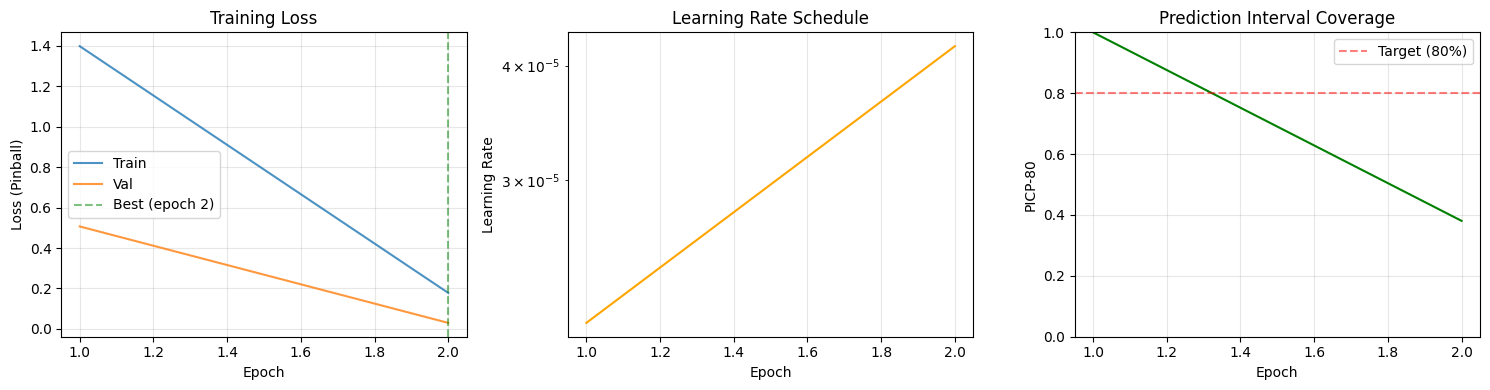

Training curves saved to /content/outputs/training_curves.png


In [14]:
def plot_training_curves(history):
    """
    Plot training and validation loss curves.

    Creates visualization of:
    1. Train/val loss over epochs
    2. Learning rate schedule
    3. PICP-80 calibration metric

    Args:
        history: Training history dictionary
    """
    import matplotlib.pyplot as plt
    import numpy as np

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    epochs = range(1, len(history['train_loss']) + 1)

    # Loss curves
    ax = axes[0]
    ax.plot(epochs, history['train_loss'], label='Train', alpha=0.8)
    ax.plot(epochs, history['val_loss'], label='Val', alpha=0.8)
    best_epoch = np.argmin(history['val_loss']) + 1
    ax.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.5, label=f'Best (epoch {best_epoch})')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss (Pinball)')
    ax.set_title('Training Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Learning rate
    ax = axes[1]
    ax.plot(epochs, history['learning_rates'], color='orange')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Learning Rate')
    ax.set_title('Learning Rate Schedule')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)

    # PICP-80
    ax = axes[2]
    if history['val_metrics']:
        picp_values = [m.get('picp_80', 0.0) for m in history['val_metrics']]
        ax.plot(epochs, picp_values, color='green')
        ax.axhline(y=0.8, color='r', linestyle='--', alpha=0.5, label='Target (80%)')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('PICP-80')
        ax.set_title('Prediction Interval Coverage')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1)

    plt.tight_layout()
    plt.savefig(str(paths['vm_outputs'] / 'training_curves.png'), dpi=150)
    plt.show()

    print(f"Training curves saved to {paths['vm_outputs'] / 'training_curves.png'}")

plot_training_curves(history)

## 8. Save Results to Drive

In [15]:
def save_outputs_to_drive(vm_outputs, drive_outputs):
    """
    Copy training outputs from VM to Google Drive for persistence.

    Colab VM storage is ephemeral - files are lost when runtime disconnects.
    This copies checkpoints and training history to Drive for:
    - Model persistence
    - Resume capability
    - Phase 6 evaluation

    Files copied:
    - checkpoint_best.pt: Best model for inference
    - checkpoint_latest.pt: For resuming training
    - training_history.json: Loss curves and metrics
    - training_curves.png: Visualization
    - checkpoint_epoch_XXX.pt: Top-k checkpoints

    Args:
        vm_outputs: Path to outputs on VM
        drive_outputs: Path to outputs on Drive
    """
    import shutil
    from pathlib import Path

    vm_outputs = Path(vm_outputs)
    drive_outputs = Path(drive_outputs)

    print("Copying outputs to Google Drive...")

    # Essential files to copy
    essential_files = [
        'checkpoint_best.pt',
        'checkpoint_latest.pt',
        'training_history.json',
        'training_curves.png'
    ]

    for filename in essential_files:
        src = vm_outputs / filename
        dst = drive_outputs / filename
        if src.exists():
            shutil.copy2(src, dst)
            print(f"  Copied: {filename} ({src.stat().st_size / 1e6:.1f} MB)")
        else:
            print(f"  Warning: {filename} not found")

    # Copy epoch checkpoints
    for ckpt_file in vm_outputs.glob('checkpoint_epoch_*.pt'):
        dst = drive_outputs / ckpt_file.name
        shutil.copy2(ckpt_file, dst)
        print(f"  Copied: {ckpt_file.name}")

    print(f"\nOutputs saved to: {drive_outputs}")
    print("\nFiles for Phase 6 evaluation:")
    print(f"  Best model: {drive_outputs / 'checkpoint_best.pt'}")
    print(f"  History: {drive_outputs / 'training_history.json'}")

save_outputs_to_drive(paths['vm_outputs'], paths['drive_outputs'])

Copying outputs to Google Drive...
  Copied: checkpoint_best.pt (82.7 MB)
  Copied: checkpoint_latest.pt (82.7 MB)
  Copied: training_history.json (0.0 MB)
  Copied: training_curves.png (0.1 MB)
  Copied: checkpoint_epoch_001.pt
  Copied: checkpoint_epoch_000.pt

Outputs saved to: /content/drive/MyDrive/Colab Notebooks/Transformers/FP/outputs

Files for Phase 6 evaluation:
  Best model: /content/drive/MyDrive/Colab Notebooks/Transformers/FP/outputs/checkpoint_best.pt
  History: /content/drive/MyDrive/Colab Notebooks/Transformers/FP/outputs/training_history.json


In [16]:
def cleanup_wandb(wandb_logger):
    """
    Finalize WandB run if enabled.

    Args:
        wandb_logger: WandB module or None
    """
    if wandb_logger is not None:
        wandb_logger.finish()
        print("WandB run finalized")

cleanup_wandb(wandb_logger)

## 9. Final Status

In [17]:
def print_final_status(paths, history):
    """
    Print final training status and next steps.

    Args:
        paths: Path configuration dictionary
        history: Training history dictionary
    """
    import numpy as np

    print("="*60)
    print("TRAINING COMPLETE - FINAL STATUS")
    print("="*60)
    print()

    n_epochs = len(history['train_loss'])
    best_epoch = np.argmin(history['val_loss']) + 1
    best_val_loss = history['val_loss'][best_epoch - 1]

    print(f"Training completed: {n_epochs} epochs")
    print(f"Best model: epoch {best_epoch} (val_loss: {best_val_loss:.6f})")
    print()

    print("Output files on Drive:")
    drive_outputs = paths['drive_outputs']
    for f in ['checkpoint_best.pt', 'checkpoint_latest.pt', 'training_history.json']:
        fpath = drive_outputs / f
        if fpath.exists():
            print(f"  {f}: {fpath.stat().st_size / 1e6:.1f} MB")

    print()
    print("Next Steps (Phase 6 - Evaluation):")
    print("  1. Load best checkpoint")
    print("  2. Run inference on test set")
    print("  3. Compute distributional metrics (CRPS, calibration)")
    print("  4. Compute financial metrics (Sharpe, MDD)")
    print("  5. Generate evaluation report")

print_final_status(paths, history)

TRAINING COMPLETE - FINAL STATUS

Training completed: 2 epochs
Best model: epoch 2 (val_loss: 0.029510)

Output files on Drive:
  checkpoint_best.pt: 82.7 MB
  checkpoint_latest.pt: 82.7 MB
  training_history.json: 0.0 MB

Next Steps (Phase 6 - Evaluation):
  1. Load best checkpoint
  2. Run inference on test set
  3. Compute distributional metrics (CRPS, calibration)
  4. Compute financial metrics (Sharpe, MDD)
  5. Generate evaluation report


---

## Appendix: Quick Reference

### Resume Training
```python
RESUME_FROM_CHECKPOINT = paths['drive_outputs'] / 'checkpoint_latest.pt'
```

### Enable WandB
```python
USE_WANDB = True
```

### Load Best Model for Inference
```python
checkpoint = torch.load(paths['drive_outputs'] / 'checkpoint_best.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
```

### Expected Output Shapes
- Input features: (B, 288, 24)
- Attention mask: (B, 288)
- Output quantiles: (B, 5, 7) = (batch, horizons, quantiles)